In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup as bs
import numpy as np
from datetime import datetime
import re
from sklearn.impute import KNNImputer
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostRegressor


In [ ]:
#Gathering all the game links by iterating through every page on the website
base_url = "https://www.mobygames.com"
game_links = []
for i in range(0, 165):
    response = requests.get(base_url + f"/platform/xbox-one/page:{i}/")
    soup = bs(response.content, 'html.parser')
    game_links.extend(soup.select('td.text-nowrap a'))
for i in range(0, len(game_links)):
    game_links[i] = game_links[i]['href']


In [ ]:
#Function for extracting the string values from the requests we'll make
def func(element):
    return element.string

In [ ]:
#Code to iterate throught the links and pull out various information
name = []
release_date = []
credits = []
developers = []
genre = []
gameplay = []
interface = []
narrative = []
esrb = []
number_collected = []
price = []
game_score = []

for link in game_links:
    game = requests.get(link)
    game_specs = requests.get(link+'specs/')
    game_xbox = requests.get(link+'specs/xbox-one')
    game_soup = bs(game.content, 'html.parser')
    name.append(list(map(func, game_soup.select('.flex-space-between .mb-0'))))
    game_specs_soup = bs(game_specs.content, 'html.parser')
    game_xbox_soup = bs(game_xbox.content, 'html.parser')
    name2 = name[game_links.index(link)][0].strip().replace(' ', '-')
    game_price = requests.get(f'https://www.pricecharting.com/game/xbox-one/{name2}?q={name[game_links.index(link)][0].strip()}')
    game_price_soup = bs(game_price.content, 'html.parser')

    release_date.append(list(map(func, game_soup.select('.info-release dd:nth-child(2) a:nth-child(1)'))))
    credits.append(list(map(func, game_soup.select('.info-release dd~ dd > a:nth-child(1)'))))
    developers.append(list(map(func, game_soup.select('#developerLinks a'))))
    genre.append(list(map(func, game_soup.select('.info-genres dd:nth-child(2) a'))))
    gameplay.append(list(map(func, game_soup.select('.info-genres dd:nth-child(6) a'))))
    interface.append(list(map(func, game_soup.select('.info-genres dd:nth-child(8) a'))))
    narrative.append(list(map(func, game_soup.select('dd:nth-child(12) a'))))
    esrb.append(list(map(func, game_specs_soup.select('tr:nth-child(2) .img-rating+ a'))))
    number_collected.append(list(map(func, game_soup.select('.info-score dd:nth-child(10)'))))
    price.append(list(map(func, game_price_soup.select('#new_price .price'))))
    game_score.append(list(map(func, game_soup.select('.mobyscore'))))



In [ ]:
#Data table to put in the df
data = {
    'name': name,
    'release_date': release_date,
    'credits': credits,
    'developer': developers,
    'genre': genre,
    'gameplay': gameplay,
    'interface': interface,
    'narrative': narrative,
    'esrb': esrb,
    'number_collected': number_collected,
    'price': price,
    'game_score': game_score
}

In [887]:
#Just making a copy of the original df so that we don't have to run the webscraping portion again
original_df = pd.DataFrame(data=data)
game_df = original_df.copy(deep=True)

In [888]:
#Various methods to help fix the data
def split_element1(element):
    if element is not None and len(element) > 1:
        return [element[0]]
    return element

def quantity_check(element):
    if element is not None:
        return len(element) > 1

def esrb_correction(element):
    if any(str(num) in str(item) for num in [17, 18] for item in element) or "Mature" in element:
        return 'Mature'
    elif any(str(num) in str(item) for num in range(13, 17) for item in element) or "Teen" in element:
        return 'Teen'
    elif any(str(num) in str(item) for num in range(1, 13) for item in element) or "Everyone" in element:
        return "Everyone"
    return None
    

In [889]:
#Fixing esrb and extracting the rest of the data from list form
game_df['esrb'] = game_df['esrb'].apply(esrb_correction)
element_df = game_df.map(quantity_check)
greater_than_one = element_df.any(axis=0)
hard_columns = game_df.loc[:, greater_than_one]
hard_columns.drop('esrb', axis=1, inplace=True)
for col in hard_columns:
    game_df[col] = game_df[col].apply(split_element1)

game_df.head()

C:\Users\ethan\AppData\Local\Temp\ipykernel_42428\3333044710.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hard_columns.drop('esrb', axis=1, inplace=True)


,name,release_date,credits,developer,genre,gameplay,interface,narrative,esrb,number_collected,price,game_score
0,[Grand Theft Auto V],"[\n September 17, 2013\n ]","[3,770 people]",[Rockstar North Ltd.],[Action],[Sandbox / open world],[Direct control],[Crime],Mature,[795 players],[\n $14.99\n ...,[\n 8.9\n ]
1,[Inside],"[\n June 29, 2016\n ]",[112 people],[Playdead ApS],[Action],[2D scrolling],[Platform],[Thriller],Mature,[303 players],[],[\n 8.7\n ]
2,[Resident Evil 2],"[\n January 25, 2019\n ]","[1,093 people]","[Capcom Co., Ltd.]",[Action],[Puzzle elements],[Direct control],[Horror],Mature,[275 players],[\n $19.18\n ...,[\n 9.0\n ]
3,[Red Dead Redemption II],"[\n October 26, 2018\n ]","[7,313 people]",[Rockstar Games Toronto ULC],[Action],[Gambling elements],[Direct control],[Crime],Mature,[395 players],[],[\n 9.1\n ]
4,[Forza Horizon 4],"[\n October 2, 2018\n ]","[1,833 people]",[Playground Games Ltd],[Racing / Driving],[Direct control],[Automobile],[],Everyone,[127 players],[\n $35.11\n ...,[\n 8.6\n ]


In [890]:
#Fixing the lists in the data
def extract_lists(element):
    if element is not None and isinstance(element, list) and len(element) > 0:
        return element[0].strip()

for col in game_df.columns.difference(['esrb']):
    game_df[col] = game_df[col].apply(extract_lists)

game_df.head()

,name,release_date,credits,developer,genre,gameplay,interface,narrative,esrb,number_collected,price,game_score
0,Grand Theft Auto V,"September 17, 2013","3,770 people",Rockstar North Ltd.,Action,Sandbox / open world,Direct control,Crime,Mature,795 players,$14.99,8.9
1,Inside,"June 29, 2016",112 people,Playdead ApS,Action,2D scrolling,Platform,Thriller,Mature,303 players,None,8.7
2,Resident Evil 2,"January 25, 2019","1,093 people","Capcom Co., Ltd.",Action,Puzzle elements,Direct control,Horror,Mature,275 players,$19.18,9.0
3,Red Dead Redemption II,"October 26, 2018","7,313 people",Rockstar Games Toronto ULC,Action,Gambling elements,Direct control,Crime,Mature,395 players,None,9.1
4,Forza Horizon 4,"October 2, 2018","1,833 people",Playground Games Ltd,Racing / Driving,Direct control,Automobile,None,Everyone,127 players,$35.11,8.6


In [891]:
# Fixing date to be more influential
def date(element):
    if element is not None and not element[0].isdigit() and ',' in element:
        old_date = datetime.strptime(element, r'%B %d, %Y')
        current_date = datetime.strptime('December 1, 2024', r'%B %d, %Y')
        return (current_date - old_date).days
    elif element is not None and element[0].isdigit():
        newelement = (2024 - int(element))
        return newelement * 365.2
    elif element is not None:
        old_date = datetime.strptime(element, r'%B %Y')
        current_date = datetime.strptime('December 2024', r'%B %Y')
        return (current_date - old_date).days

game_df['release_date'] = game_df['release_date'].apply(date)
game_df = game_df.rename(columns={'release_date': 'days_since_release'})
game_df.head()


,name,days_since_release,credits,developer,genre,gameplay,interface,narrative,esrb,number_collected,price,game_score
0,Grand Theft Auto V,4093.0,"3,770 people",Rockstar North Ltd.,Action,Sandbox / open world,Direct control,Crime,Mature,795 players,$14.99,8.9
1,Inside,3077.0,112 people,Playdead ApS,Action,2D scrolling,Platform,Thriller,Mature,303 players,None,8.7
2,Resident Evil 2,2137.0,"1,093 people","Capcom Co., Ltd.",Action,Puzzle elements,Direct control,Horror,Mature,275 players,$19.18,9.0
3,Red Dead Redemption II,2228.0,"7,313 people",Rockstar Games Toronto ULC,Action,Gambling elements,Direct control,Crime,Mature,395 players,None,9.1
4,Forza Horizon 4,2252.0,"1,833 people",Playground Games Ltd,Racing / Driving,Direct control,Automobile,None,Everyone,127 players,$35.11,8.6


In [892]:
#Before splitting to encode, I want to fix the data into various numerical formats
def fix_numerical(element):
    if element is not None:
        new_element = re.sub('[^0-9]','', element)
        if new_element == '':
            return None
        return new_element

cols = ['credits', 'number_collected']
for col in cols:
    game_df[col] = game_df[col].apply(fix_numerical)

game_df.head()

,name,days_since_release,credits,developer,genre,gameplay,interface,narrative,esrb,number_collected,price,game_score
0,Grand Theft Auto V,4093.0,3770,Rockstar North Ltd.,Action,Sandbox / open world,Direct control,Crime,Mature,795,$14.99,8.9
1,Inside,3077.0,112,Playdead ApS,Action,2D scrolling,Platform,Thriller,Mature,303,None,8.7
2,Resident Evil 2,2137.0,1093,"Capcom Co., Ltd.",Action,Puzzle elements,Direct control,Horror,Mature,275,$19.18,9.0
3,Red Dead Redemption II,2228.0,7313,Rockstar Games Toronto ULC,Action,Gambling elements,Direct control,Crime,Mature,395,None,9.1
4,Forza Horizon 4,2252.0,1833,Playground Games Ltd,Racing / Driving,Direct control,Automobile,None,Everyone,127,$35.11,8.6


In [893]:
#Fill in missing values for MCAR columns
def fix_price(element):
    if element is not None:
        newelement = element.replace('$', '').replace('-', '')
        if newelement == '':
            return None
        return newelement
game_df['price'] = game_df['price'].apply(fix_price)

float_cols = ['credits', 'number_collected', 'game_score', 'price', 'days_since_release']
for col in float_cols:
    game_df[col] = game_df[col].astype('float64')

missing_cols = ['price', 'credits']
for col in missing_cols:
    game_df[col] = game_df[col].fillna(game_df[col].mean())
game_df['esrb'] = game_df['esrb'].fillna('Unrated')
game_df['number_collected'] = game_df['number_collected'].fillna(0)

game_df.dtypes

name                   object
days_since_release    float64
credits               float64
developer              object
genre                  object
gameplay               object
interface              object
narrative              object
esrb                   object
number_collected      float64
price                 float64
game_score            float64
dtype: object

In [894]:
game_df.head()

,name,days_since_release,credits,developer,genre,gameplay,interface,narrative,esrb,number_collected,price,game_score
0,Grand Theft Auto V,4093.0,3770.0,Rockstar North Ltd.,Action,Sandbox / open world,Direct control,Crime,Mature,795.0,14.990000,8.9
1,Inside,3077.0,112.0,Playdead ApS,Action,2D scrolling,Platform,Thriller,Mature,303.0,20.678903,8.7
2,Resident Evil 2,2137.0,1093.0,"Capcom Co., Ltd.",Action,Puzzle elements,Direct control,Horror,Mature,275.0,19.180000,9.0
3,Red Dead Redemption II,2228.0,7313.0,Rockstar Games Toronto ULC,Action,Gambling elements,Direct control,Crime,Mature,395.0,20.678903,9.1
4,Forza Horizon 4,2252.0,1833.0,Playground Games Ltd,Racing / Driving,Direct control,Automobile,None,Everyone,127.0,35.110000,8.6


In [895]:
#Making the rest of the categorical missing data into "Missing" for one hot encoding and dropping name
game_df = game_df.fillna('Missing')
game_df.drop('name', axis=1, inplace=True)

In [896]:
#One hot encoding the data
game_df = pd.get_dummies(game_df, columns=['developer', 'genre', 'gameplay', 'interface', 'narrative', 'esrb'])
game_df = game_df.replace({False: 0, True: 1})
game_df

C:\Users\ethan\AppData\Local\Temp\ipykernel_42428\22590774.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  game_df = game_df.replace({False: 0, True: 1})


,days_since_release,credits,number_collected,price,game_score,developer_11 bit studios S.A.,developer_2K Australia Pty. Ltd,developer_3 Sprockets Pty Ltd,"developer_343 Industries, Inc.",developer_4A Games Limited,...,narrative_Regional differences,narrative_Sci-fi / futuristic,narrative_Space flight,narrative_Spy / espionage,narrative_Thriller,narrative_War,esrb_Everyone,esrb_Mature,esrb_Teen,esrb_Unrated
0,4093.0,3770.0,795.0,14.990000,8.9,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,3077.0,112.0,303.0,20.678903,8.7,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,2137.0,1093.0,275.0,19.180000,9.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2228.0,7313.0,395.0,20.678903,9.1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2252.0,1833.0,127.0,35.110000,8.6,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8245,2102.0,466.0,63.0,33.360000,7.2,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8246,2056.0,466.0,39.0,9.730000,7.2,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8247,3673.0,3617.0,190.0,13.660000,7.1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8248,2931.0,411.0,226.0,22.760000,7.7,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [897]:
#Splitting
X = game_df.drop(["game_score"], axis=1)
y = game_df["game_score"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

In [898]:
#Scaling
scaler = StandardScaler()
columns_to_scale = ['days_since_release', 'credits', 'number_collected', 'price']
columns_no_scale = [col for col in X_train.columns if col not in columns_to_scale]
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', scaler, columns_to_scale),
        ('no_scaler', 'passthrough', columns_no_scale)
    ]
)
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)
X_train_scaled = pd.DataFrame(X_train, columns=columns_to_scale + columns_no_scale)
X_test_scaled = pd.DataFrame(X_test, columns=columns_to_scale + columns_no_scale)

In [899]:
#Linear Regression
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)
y_pred = reg.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"The mse is {mse} and the r^2 value is {r2}")

The mse is 0.0547649800353629 and the r^2 value is 0.2966568127505359


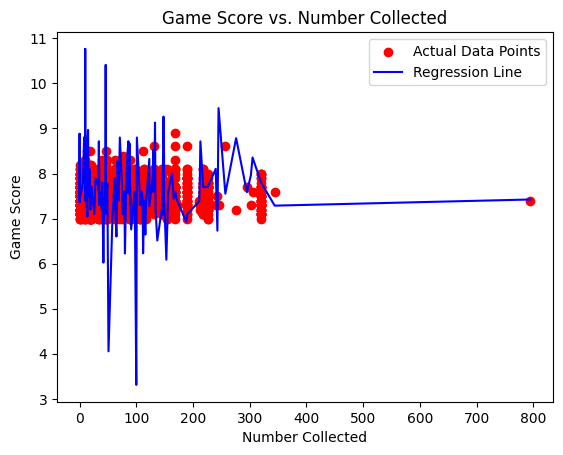

In [900]:
#Showing a possible relation between number of collected copies and the game score
sorted_indices = X_test['number_collected'].argsort()  # Sort indices by the feature
X_test_sorted = X_test.iloc[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

plt.scatter(X_test_sorted['number_collected'], y_test, color='red', label = 'Actual Data Points')
plt.plot(X_test_sorted['number_collected'], y_pred_sorted, color='blue', label='Regression Line')

plt.xlabel('Number Collected')
plt.ylabel('Game Score')
plt.title('Game Score vs. Number Collected')
plt.legend()

plt.show()

In [901]:
#Trying out the AdaBoostRegressor
ada = AdaBoostRegressor()
ada.fit(X_train_scaled, y_train)
y_pred = ada.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"The mse is {mse} and the r^2 value is {r2}")

The mse is 0.0434540012059451 and the r^2 value is 0.44192300102736704


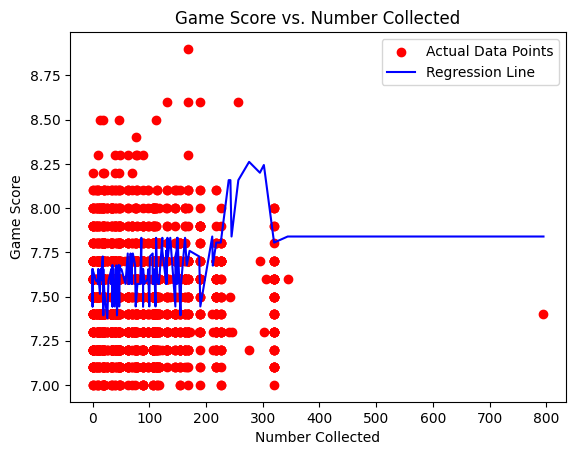

In [902]:
#Showing a possible relation between number of collected copies and the game score again
y_pred_sorted = y_pred[sorted_indices]

plt.scatter(X_test_sorted['number_collected'], y_test, color='red', label = 'Actual Data Points')
plt.plot(X_test_sorted['number_collected'], y_pred_sorted, color='blue', label='Regression Line')

plt.xlabel('Number Collected')
plt.ylabel('Game Score')
plt.title('Game Score vs. Number Collected')
plt.legend()

plt.show()